In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as matplotcolors
import matplotlib.patches as matplotpatches
from matplotlib.ticker import AutoMinorLocator
import networkx as nx
import numpy as np
import itertools
from scipy import optimize
import seaborn as sb

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
    '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
    return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
# dataframe creation

df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
# data cleaning: removing positive signal intensities
df_bt = df_bt[df_bt["rssi"] <= 0]
# data cleaning: marking contacts with non-partecipants as empty scans
df_bt["rssi"][df_bt["user_b"] == -2] = 0
df_bt["user_b"].replace(-2, -1, inplace=True)
# inserting column for strong/weak contacts
df_bt["weight"] = (df_bt["rssi"] >= -80) & (df_bt["rssi"] != 0)
print("bluetooth\n", df_bt.head())

df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
print("\ncalls\n", df_calls.head())

df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)
print("\nsms\n", df_sms.head())

df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
# data cleaning: removing self-friendships
df_facebook_friends = df_facebook_friends[df_facebook_friends["user_b"] != df_facebook_friends["# user_a"]]
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
# data reshaping
df_genders = df_genders.set_index("# user")
reshape_dict = {1 : "female", 0 : "male"}
df_genders["gender"] = df_genders["female"].map(reshape_dict)
df_genders.drop(columns="female", inplace=True)
print("\ngenders\n", df_genders.head())

bluetooth
    # timestamp  user_a  user_b  rssi  weight
0            0       0      -1     0   False
1            0       1      -1     0   False
2            0       2      -1     0   False
3            0       3      -1     0   False
4            0       5      -1     0   False

calls
    timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
3       9252     401     457        -1
4      15466     512       0         5

sms
    timestamp  sender  recipient
0         18     370        512
1         37     512        370
2        126     370        512
3        134       0        512
4        312     137        136

facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders
        gender
# user       
0        male
2        male
3        male
4        male
5        male


In [5]:
def aggregateStrongConnections(dataframe, hrs):
    df = dataframe.copy()
    df.drop(columns="rssi", inplace=True)
    df["# timestamp"] = df["# timestamp"] // (60*60*hrs) * (60*60*hrs)
    df = df.groupby(["# timestamp","user_a","user_b"]).sum() / (60*60*hrs/5/60)
    df.reset_index(inplace=True)
    return df

In [6]:
def createTimeGraphs(dataframe):
    graphs = [nx.from_pandas_edgelist(group, source="user_a", target="user_b", edge_attr="weight")
              for t,group in dataframe.groupby("# timestamp")]
    for G in graphs:
        G.remove_node(-1)
        [G.remove_edge(*edge) for edge,weight in nx.get_edge_attributes(G,"weight").items() if weight == 0]
        nx.set_node_attributes(G, df_genders.to_dict(orient="index"))
        g_distance_dict = {(n1, n2): 1 / weight for n1, n2, weight in G.edges(data='weight')}
        nx.set_edge_attributes(G, g_distance_dict, 'distance')
    return graphs

In [7]:
def getTimestamp(week, day, hour):
    return ((week * 7 + day) * 24 + hour) * 60 * 60

In [8]:
bt_1m = aggregateStrongConnections(df_bt, 24*28)
bt_1m_selected = bt_1m
graphs_1m = createTimeGraphs(bt_1m_selected)

### Resolution = 0.5

For resolution = 0.5 there are 41 communities


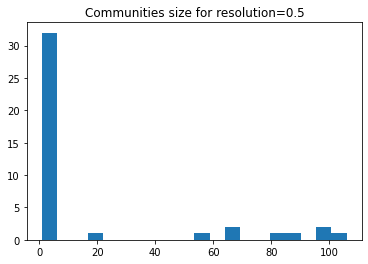

Communities are:
{9}
{321, 322}
{512, 6, 518, 270, 271, 272, 528, 274, 531, 19, 536, 538, 27, 287, 32, 289, 546, 291, 548, 36, 550, 37, 296, 41, 48, 49, 308, 569, 315, 61, 323, 68, 583, 330, 588, 589, 76, 79, 595, 347, 94, 355, 99, 615, 616, 619, 107, 109, 366, 365, 112, 625, 124, 382, 383, 642, 130, 644, 392, 395, 652, 400, 147, 404, 405, 668, 157, 158, 415, 677, 165, 166, 426, 682, 171, 688, 178, 437, 438, 443, 191, 196, 710, 200, 457, 201, 465, 211, 469, 218, 477, 478, 479, 484, 230, 487, 250, 510}
{60}
{0, 513, 258, 259, 514, 519, 523, 12, 13, 14, 525, 526, 529, 532, 278, 25, 539, 28, 285, 31, 547, 35, 555, 44, 302, 561, 55, 317, 576, 69, 582, 72, 584, 586, 845, 78, 590, 336, 335, 82, 339, 85, 597, 87, 349, 350, 351, 356, 613, 359, 108, 367, 624, 371, 632, 379, 636, 637, 128, 129, 645, 389, 136, 137, 650, 654, 399, 145, 148, 149, 662, 663, 409, 667, 155, 673, 418, 422, 167, 423, 170, 429, 430, 692, 185, 186, 702, 703, 448, 454, 462, 208, 210, 213, 214, 215, 216, 473, 480, 483, 228,

In [18]:
resolution = 0.5

community_1m = [nx.algorithms.community.louvain_communities(G, weight="weight", resolution=resolution) for G in graphs_1m]

print(f"For resolution = {resolution} there are {len(community_1m[0])} communities")
plt.hist([len(community) for community in community_1m[0]], bins=20)
plt.title(f"Communities size for resolution={resolution}")
plt.show()
print("Communities are:")
for community in community_1m[0]:
    print(community)

### Resolution = 1

For resolution = 1 there are 52 communities


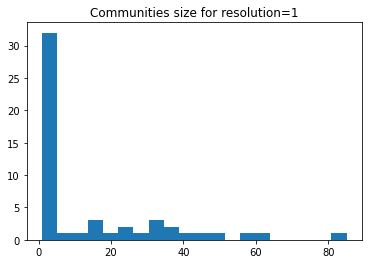

Communities are:
{516, 70, 8, 138, 592, 337, 533, 214, 608, 419, 620, 557, 45, 430, 303, 624, 53}
{9}
{382, 710, 270, 528, 274, 147, 469, 218, 347, 157, 478, 479, 32, 700, 61, 510}
{512, 130, 642, 644, 518, 6, 392, 271, 272, 400, 405, 536, 538, 27, 668, 158, 287, 415, 289, 36, 165, 550, 166, 296, 41, 682, 171, 426, 37, 46, 48, 49, 688, 178, 308, 438, 443, 315, 323, 196, 200, 201, 330, 457, 79, 211, 94, 223, 355, 484, 615, 487, 616, 619, 109, 366, 112, 625, 124, 383}
{60}
{262, 263, 395, 652, 657, 531, 19, 404, 537, 546, 291, 548, 677, 294, 43, 52, 437, 191, 194, 451, 68, 324, 583, 588, 589, 76, 595, 212, 340, 598, 472, 601, 477, 221, 99, 230, 107, 236, 365, 370, 250, 126}
{103}
{110}
{117}
{579, 5, 73, 267, 269, 527, 655, 466, 402, 403, 150, 471, 602, 475, 412, 222, 543, 375, 482, 486, 42, 173, 496, 432, 689, 115, 54, 631, 120, 314, 699, 444, 573}
{128, 641, 578, 3, 260, 261, 71, 199, 521, 458, 459, 396, 141, 268, 593, 146, 151, 280, 600, 97, 611, 357, 38, 102, 684, 364, 239, 176, 113,

In [13]:
resolution = 1

community_1m = [nx.algorithms.community.louvain_communities(G, weight="weight", resolution=resolution) for G in graphs_1m]

print(f"For resolution = {resolution} there are {len(community_1m[0])} communities")
plt.hist([len(community) for community in community_1m[0]], bins=20)
plt.title(f"Communities size for resolution={resolution}")
plt.show()
print("Communities are:")
for community in community_1m[0]:
    print(community)

### Resolution = 5

For resolution = 5 there are 83 communities


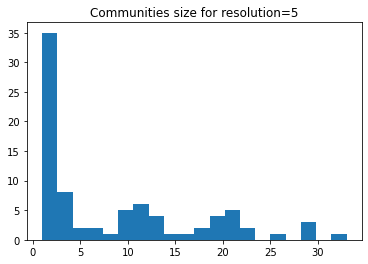

Communities are:
{9}
{16, 306, 572, 541}
{128, 35, 525, 529, 595, 19, 87, 123}
{512, 355, 36, 37, 484, 296, 201, 79, 400, 211, 538}
{370, 148, 532, 69, 44}
{48, 49, 171}
{60}
{516, 70, 138, 45, 430, 303, 624, 337, 53, 214}
{579, 5, 73, 267, 269, 527, 402, 403, 466, 150, 471, 602, 475, 412, 222, 543, 482, 486, 42, 173, 432, 689, 496, 115, 54, 120, 314, 444, 573}
{640, 386, 643, 585, 394, 140, 397, 273, 341, 408, 89, 92, 223, 224, 95, 676, 551, 232, 425, 172, 567}
{96, 681, 634, 677}
{103}
{110}
{334, 207, 18, 659, 467, 407, 88, 665, 476, 29, 290, 378, 114, 563, 691, 627, 376, 505, 570, 125, 254}
{628, 468, 116, 421, 414}
{117}
{228, 709, 454, 136, 137, 650, 235, 488, 654, 145, 411, 597, 181, 667, 350}
{641, 261, 71, 199, 458, 396, 141, 593, 151, 280, 97, 38, 102, 684, 364, 113, 247, 571, 445}
{384, 1, 64, 451, 453, 204, 17, 596, 212, 599, 345, 474, 537, 57, 161, 163, 164, 101, 549, 680, 361, 43, 494, 559, 304, 240, 633, 126, 639}
{673, 637, 253}
{449, 46, 47, 284}
{685, 182, 183}
{184}


In [15]:
resolution = 5

community_1m = [nx.algorithms.community.louvain_communities(G, weight="weight", resolution=resolution) for G in graphs_1m]

print(f"For resolution = {resolution} there are {len(community_1m[0])} communities")
plt.hist([len(community) for community in community_1m[0]], bins=20)
plt.title(f"Communities size for resolution={resolution}")
plt.show()
print("Communities are:")
for community in community_1m[0]:
    print(community)

### Resolution = 10

For resolution = 10 there are 116 communities


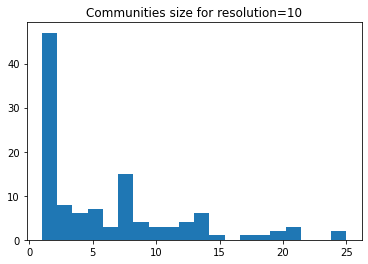

Communities are:
{128, 145, 3, 357, 239}
{73, 5}
{9}
{25, 13, 12, 244}
{20, 21}
{512, 355, 36, 37, 484, 296, 201, 79, 400, 211, 538}
{579, 267, 269, 527, 402, 403, 150, 471, 602, 475, 412, 222, 543, 482, 486, 42, 432, 689, 115, 54, 120, 314, 699, 444, 573}
{148, 69, 44, 532}
{516, 70, 138, 236, 45, 303, 337, 53}
{48, 49, 171}
{657, 52, 324, 262, 472, 263, 221}
{509, 67, 388, 195, 198, 139, 591, 15, 344, 30, 416, 481, 353, 552, 233, 568, 177, 56, 506, 507, 381}
{59, 732, 575}
{60}
{32, 382, 510, 710, 528, 274, 147, 61, 469, 218, 347, 157, 478, 479}
{105, 83}
{640, 386, 643, 131, 585, 394, 140, 397, 273, 408, 24, 92, 95, 224, 223, 676, 551, 232, 425, 172, 567}
{96, 677, 681, 634, 700}
{103}
{288, 121, 104, 169, 401, 62, 286}
{465, 569}
{110}
{117}
{257, 707, 197, 455, 522, 331, 343, 282, 159, 545, 225, 227, 553, 621, 174, 436, 118, 439, 251, 574}
{175, 119}
{144, 4, 181, 709, 488, 411}
{418, 259, 359, 72, 429, 78, 82, 692, 149, 702}
{165, 166}
{129, 258, 645, 462, 590, 14, 213, 215, 216,

In [16]:
resolution = 10

community_1m = [nx.algorithms.community.louvain_communities(G, weight="weight", resolution=resolution) for G in graphs_1m]

print(f"For resolution = {resolution} there are {len(community_1m[0])} communities")
plt.hist([len(community) for community in community_1m[0]], bins=20)
plt.title(f"Communities size for resolution={resolution}")
plt.show()
print("Communities are:")
for community in community_1m[0]:
    print(community)

### Resolution = 50

For resolution = 20 there are 176 communities


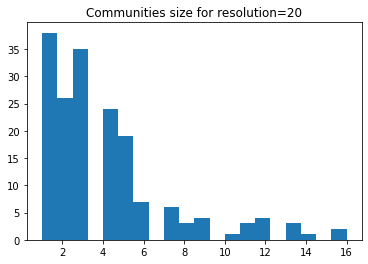

Communities are:
{345, 1, 555}
{3, 259, 357}
{426, 27, 668, 6}
{9}
{226, 515, 10, 11, 492, 461}
{16, 306, 572, 541}
{20, 21}
{658, 22, 651, 220, 623}
{29, 254}
{36, 37}
{432, 573, 42, 699, 314, 543, 527}
{148, 532, 69, 44}
{449, 284, 46, 47}
{48, 49, 171}
{481, 388, 198, 56, 506}
{59, 732, 575}
{60}
{337, 516, 53, 70, 138, 45, 303}
{73, 5}
{576, 385, 84}
{704, 649, 90, 91, 318, 319}
{386, 643, 676, 567, 92}
{103}
{105, 83}
{110}
{80, 75, 373, 111}
{376, 114}
{482, 68, 486, 689, 402, 115, 54, 471, 120, 412, 475, 444, 222}
{628, 468, 116, 421, 414}
{117}
{136, 137, 650, 667}
{546, 139, 597}
{394, 140}
{144, 181, 709, 488, 411}
{149, 359, 72, 78}
{641, 261, 38, 71, 458, 396, 113, 593, 151, 280, 571}
{192, 326, 203, 338, 562, 694, 311, 154, 93}
{165, 166}
{258, 423, 167, 28, 590, 14, 349, 302, 215, 216, 508, 317}
{272, 196}
{145, 228, 350}
{100, 182, 183}
{184}
{480, 448, 185, 356, 526, 210, 409, 186, 539}
{202}
{535, 229, 614, 7, 205}
{560, 428, 206}
{218, 382}
{224, 223}
{225, 545, 227, 

In [20]:
resolution = 20

community_1m = [nx.algorithms.community.louvain_communities(G, weight="weight", resolution=resolution) for G in graphs_1m]

print(f"For resolution = {resolution} there are {len(community_1m[0])} communities")
plt.hist([len(community) for community in community_1m[0]], bins=20)
plt.title(f"Communities size for resolution={resolution}")
plt.show()
print("Communities are:")
for community in community_1m[0]:
    print(community)